# Stencil Penalty based Contrained Immersed Boundary Method
---

### Author: Marin Lauber

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import NSsolver as ns
try:
    plt.style.use("jupyter")
except OSerror:
    print("Using default ploting style")

The stencil penalty based constrained immersed boundary method (SPcIB), see [Bale et al. (2020)](https://www.sciencedirect.com/science/article/pii/S0045793018308272), is based on the standard IB method with a singluar force

\begin{equation}
    \begin{split}
    &\frac{\partial \vec{u}}{\partial t} + (\vec{u}\cdot\nabla)\vec{u} = -\nabla p + \frac{1}{Re}\nabla^2\vec{u} + \int\vec{f}(\vec{\xi}(s, t))\delta(\vec{\xi} - \vec{x}) \text{ d}\vec{x},\\
    &\nabla\cdot\vec{u} = 0,\\
    &\vec{u}(\vec{\xi}(s, t)) = \int_{\vec{x}}\vec{u}(\vec{x})\delta(\vec{x} - \vec{\xi} ) \text{ d}\vec{x} = \vec{u}_B(\vec{\xi}(s, t)).
\end{split}
\end{equation}

but splits the forcing into two contributions

\begin{equation}
    \vec{f}(\vec{\xi}, t) = \vec{f}_{ct}(\vec{\xi}, t) + \vec{f}_{p}(\vec{\xi}, t)
\end{equation}

where $\vec{f}_p(\vec{\xi}, t)$ is a correction term that accounts for the bad approximation of the pressure gradient with central difference stencil. It is obtained from

\begin{equation}
    \vec{f}_p(\vec{\xi}, t) = \nabla p - \hat{\nabla}p.
\end{equation}

$\hat{\nabla}$ is a modified gradient operator that penalises stencils that contain a discontinuity. Standard WENO smoothness indicators are used.

## WENO smoothing
---

The modified discrete approximation is given by

\begin{equation}
    d\hat{\phi}\vert_i = \sum_{k=1}^{r}\omega_k d\phi_k,
\end{equation}

where $d\phi_k$ is the discrete approximation of the derivative of $\phi$ on stencil $k$ using $r$ grid points, i.e. with three points, we have the forward, central and backward differencinf schemes. The standard gradient approxiation on a stencil $k$, with a mesh spacing $h$ is given by

\begin{equation}
    d\phi_k = \frac{1}{h}\sum^{r-1}_{j=0}a_{kj}^{r}\phi(i-r+k+j+2).
\end{equation}

The coefficients $a_{kj}^{r}$ depend on the type and order of the discrete gradient operator. The weight $\omega_k$ are given by by a normalisation of the weights $\psi_k$

\begin{equation}
    \omega_k = \frac{\psi_k}{\sum_{k=1}^{r}\psi_k},
\end{equation}

which are given by

\begin{equation}
    \psi_k = \frac{\gamma_k}{(\epsilon + \beta_k)^m}.
\end{equation}

$\epsilon:=1e^{-6}$ prevents the weights from diverging, $m$ and must be chosen large enough. The choice of $\gamma_k$ is not important as it is normaized after. $\beta_k$ is the smoothness parameter and is given by

\begin{equation}
    \beta_k = \sum_{p=1}^{r-1}\left(\sum_{j=0}^{r-1}d_{kjp}^{r}\phi(i-r+k+j+2)\right)^2.
\end{equation}

$d_{r}^{kjp}$ are tabulated coefficients.

### Example on a 3 point stencil

---

For a three point stencil we have $r=3$, $k=\{1, 2, 3\}$, the smoothness parameters are

$$
    \beta_k = \sum_{p=1}^{r-1}\left(\sum_{j=0}^{2}d_{kjp}^{2}\phi(i+k+j-1)\right)^2.
$$

In [70]:
def grad_c(f, dx, m=4, kappa=1, eps=1e-6, c=5):
    
    grad = np.zeros(len(f))
    
    for i in range(2, len(f)-2):
        
        # smoothness parameter
        b1 = 13./12*(f[i-2] - 2*f[i-1] + f[i])**2 + 0.25*(3*f[i-2]-4*f[i-1]+f[i])**2
        b2 = 13./12*(f[i-1] - 2*f[i] + f[i+1])**2 + 0.25*(f[i-1]-f[i+1])**2
        b3 = 13./12*(f[i] - 2*f[i+1] + f[i+2])**2 + 0.25*(3*f[i]-4*f[i+1]+f[i+2])**2
        
        #weights
        psi1 = c/(eps + b1)**m
        psi2 = c*kappa/(eps + b2)**m
        psi3 = c/(eps + b3)**m
        
        # normalized weights
        sum_i = 1./(psi1+psi2+psi3)
        w1 = psi1 * sum_i
        w2 = psi2 * sum_i
        w3 = psi3 * sum_i
        
        # candidate stencils bwd, ct, fwd
        df1 = (3*f[i]-4*f[i-1]+f[i-2]) / (2*dx)
        df2 = (f[i+1] - f[i-1]) / (2*dx)
        df3 = (-3*f[i]+4*f[i+1]-f[i+2]) / (2*dx)
        
        # weighed sum
        grad[i] = w1*df1 + w2*df2 + w3*df3
    
    # boundary point at threated with forward and backward stencils
    grad[:2] = (-3*f[ :2]+4*f[1:3]-f[2:4]) / (2*dx)
    grad[-2:]=  (3*f[-2:]-4*f[-3:-1:]+f[-4:-2]) / (2*dx)
    
    return grad

To test this WENO scheme, we use the following discontinous function

\begin{equation}
    \phi(x) = \begin{cases}
        \tanh(\alpha x) & \text{if } x \le 0.5,\\
        C + \xi + \tanh(\alpha(x-1))& \text{else }.
    \end{cases}
\end{equation}

The derivative is easily evaluated analitically

\begin{equation}
    \frac{d\phi(x)}{dx} = \begin{cases}
        \alpha (1-\tanh(\alpha x)^2) & \text{if } x \le 0.5,\\
        \alpha (1-\tanh(\alpha (x-1))^2)& \text{else }.
    \end{cases}
\end{equation}

In [84]:
def phi(x, Xi=1., alpha=1.):
    C = np.tanh(0.5*alpha) - np.tanh(-0.5*alpha)
    res = np.zeros_like(x)
    for i in range(len(x)):
        if (x[i]<=0.5):
            res[i] = np.tanh(alpha*x[i])
        else:
            res[i] = C + Xi + np.tanh(alpha*(x[i] - 1))
    return res

def dphi(x, alpha=1.):
    res = np.zeros_like(x)
    for i in range(len(x)):
        if (x[i]<=0.5):
            res[i] = alpha*(1 - np.tanh(alpha*x[i])**2)
        else:
            res[i] = alpha*(1 - np.tanh(alpha*(x[i] - 1))**2)
    return res

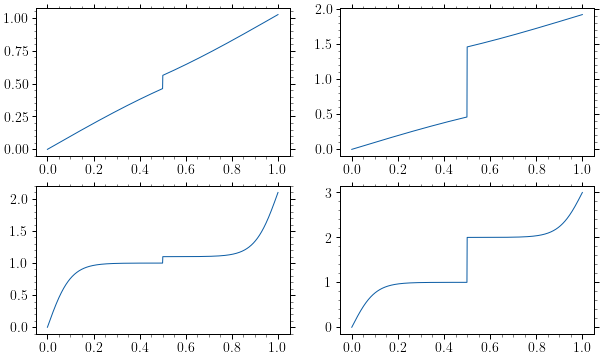

In [85]:
x, dx = np.linspace(0, 1, 1024, retstep=True)
fig, ax = plt.subplots(2, 2)
ax[0, 0].plot(x, phi(x, .1, 1))
ax[0, 1].plot(x, phi(x, 1, 1))
ax[1, 0].plot(x, phi(x, .1, 10))
ax[1, 1].plot(x, phi(x, 1, 10));

In [86]:
print("L-infinity norm of the error: %.3e" % np.max(abs(grad_c(phi(x,.1, 1), dx) - dphi(x, 1))))
print("L-infinity norm of the error: %.3e" % np.max(abs(grad_c(phi(x,1, 1), dx) - dphi(x, 1))))
print("L-infinity norm of the error: %.3e" % np.max(abs(grad_c(phi(x,.1, 10), dx) - dphi(x, 10))))
print("L-infinity norm of the error: %.3e" % np.max(abs(grad_c(phi(x,1, 10), dx) - dphi(x, 10))))

L-infinity norm of the error: 6.370e-07
L-infinity norm of the error: 6.370e-07
L-infinity norm of the error: 6.369e-04
L-infinity norm of the error: 6.369e-04


Interpolation is achieved using a standard 3-points kernel

\begin{equation}
    d(r)=\begin{cases}
        \frac{3}{4} - r^2 & \text{if } |r|\le 0.5,\\
        \frac{1}{2}(\frac{9}{4} - 3|r|+r^2)& \text{if } |r|\le 1.5,\\
        0 & \text{else.}
       \end{cases}
\end{equation}

In [41]:
def kernel(r):
    return np.where(abs(r)<=.5, .75-r**2, np.where(abs(r)<=1.5,.5*(2.25-3*abs(r)+r**2), 0))

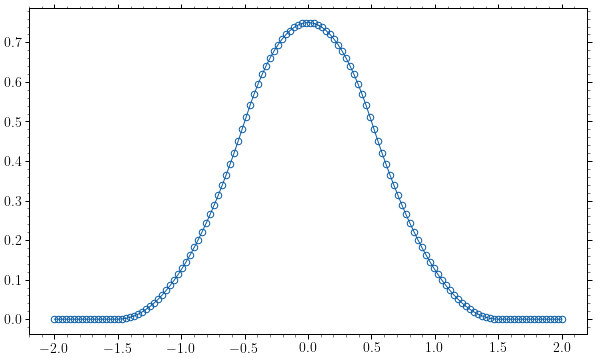

In [36]:
x, dx = np.linspace(-2, 2, 128, retstep=True)
X = 0
plt.plot(x, kernel(x-X), "-o");

In [46]:
def Ic(x, X, dx, u):
    # interpolate Eulerian velocity on Lagrangian interface
    return np.sum(u*kernel((X - x)/dx))

def Sc(x, X, F, ds=1):
    # Regularize the Lagrangian Force to the Eulerian points
    return kernel((X - x)/dx)*ds*F

We can check that the interpolation and regularization function work properly with two trivial examples. First we check that interpolating a uniform Eulerian velocity field results in the correct Lagrangian velocity

In [40]:
u0 = np.ones_like(x)
assert np.isclose(Ic(x, 0, dx, u0), 1.), "Interpolated velocity should be 1"

In [43]:
def get_f(x, X, u, V, dx, dt, rho):
    # interpolate to Lagrangian point
    Ur = Ic(x, X, dx, u)
    # compute Lagrangian force density
    F = rho/dt*(V - Ur)
    return Sc(x, X, F) # extrapolate to Eulerian points

The we can check that the forcing of a Lagrangian point moving at the same velocity as a unform Eulerian field is zero

In [44]:
assert np.allclose(get_f(x, X, u0, V, dx, 1, 1), 0.), "forcing should be zero"

## 1D Piston

The fractional step is used to solve the coupled system. The singular force is added i the predictor step, as in the IBM

$$
    u^* = u^n + \Delta t (r_{\Delta t}(u^n) + f_{ct})
$$

$$
    \nabla\cdot(\nabla p) =  \frac{\rho}{\Delta t}\nabla\cdot u^* + \nabla\cdot f_{p}
$$

$$
u^{n+1} = u^* + \frac{\Delta t}{\rho}\left(\nabla p - f_p\right)
$$

In [97]:
def update_cIB(x, X, u0, V, dx, dt=1, rho=1):
    
    u_n = u0
    flag = False
    
    for i in range(1):
        # first step
        u_1 = u_n + dt*ns.r(u_n)
        u_2 = u_1 + dt*get_f(x, X, u_1, V, dx, dt, rho)

        f_p = np.zeros_like(u_2)

        for k in range(10):

            sigma = ns.div(u_2, dx) - ns.div(f_p, dx)
            
            if k==9: flag = True
            p = ns.solve_pressure(np.ones_like(sigma), sigma, dx, verbose=flag)

            f_p = ns.grad(p, dx) - to_face(grad_c(p, dx))

        u_n = u_2 - dt/rho*(ns.grad(p, dx) - f_p)
    
    return p, u_2, sigma, u_n


def to_face(f):
    cell_c = np.zeros_like(f)
    cell_c[1:] = 0.5*(f[:-1] + f[1:])
    cell_c[0] = 0.5*(f[-1]+f[0])
    return cell_c

In [94]:
N = 24
x, dx = np.linspace(-1, 1, N, retstep=True)
xs = x + 0.5*dx # scalar cell-centred values
X = 0.
V = 1
u0 = np.zeros_like(x)
dt = 1.
d = (x-X)/dx

p, us, sigma, u_n =  update_cIB(x, X, u0, V, dx, 1, 1)
print("Interface at X: %.2f" % X)
print(r"L inf: %.3e" % np.max(np.abs(u_n -  V)))

Jacobi solver:
	res0: 2.301e-01
 	res: 2.297e-11
 	iter: 323
Interface at X: 0.00
L inf: 9.717e-01


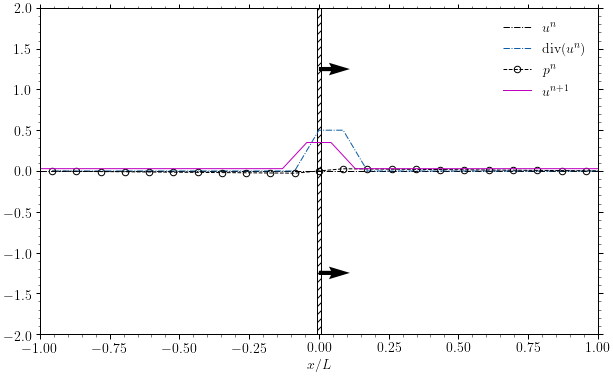

In [95]:
ns.draw_results(x, xs, X, u0, u_n, p, kernel(d))